In [169]:
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.filters import gaussian, sobel, sobel_h, sobel_v
# from skimage.morphology import skeletonize
from skimage.transform import hough_line, hough_line_peaks
import numpy as np
import math

In [35]:
CALIBRATION_LEFT_FILEPATH = '../../data/2025-06-18/calibration_left.tif'
CALIBRATION_RIGHT_FILEPATH = '../../data/2025-06-18/calibration_right.tif'

# CALIBRATION_TEST_LEFT_FILEPATH = '../../data/2025-06-13/calibration_left.tif'
# CALIBRATION_TEST_RIGHT_FILEPATH = '../../data/2025-06-13/calibration_right.tif'
# TEST_IMAGE = '../../data/toys/line_outline.png'

GRID_DIMENSIONS = (2,2)

BINARY_THRESHOLD = 3/10

ORTHOG_ERROR = 2*(np.pi) / 90 # ALLOWED ORTHOGONAL ERROR

NUM_LINES = GRID_DIMENSIONS[0] + GRID_DIMENSIONS[1] + 2
im = plt.imread(CALIBRATION_RIGHT_FILEPATH)[:,:,0]
# im = plt.imread(CALIBRATION_TEST_LEFT_FILEPATH)[:,:,0]
# im = plt.imread(CALIBRATION_TEST_RIGHT_FILEPATH)[:,:,0]


# im = plt.imread(TEST_IMAGE)[:,:,0]


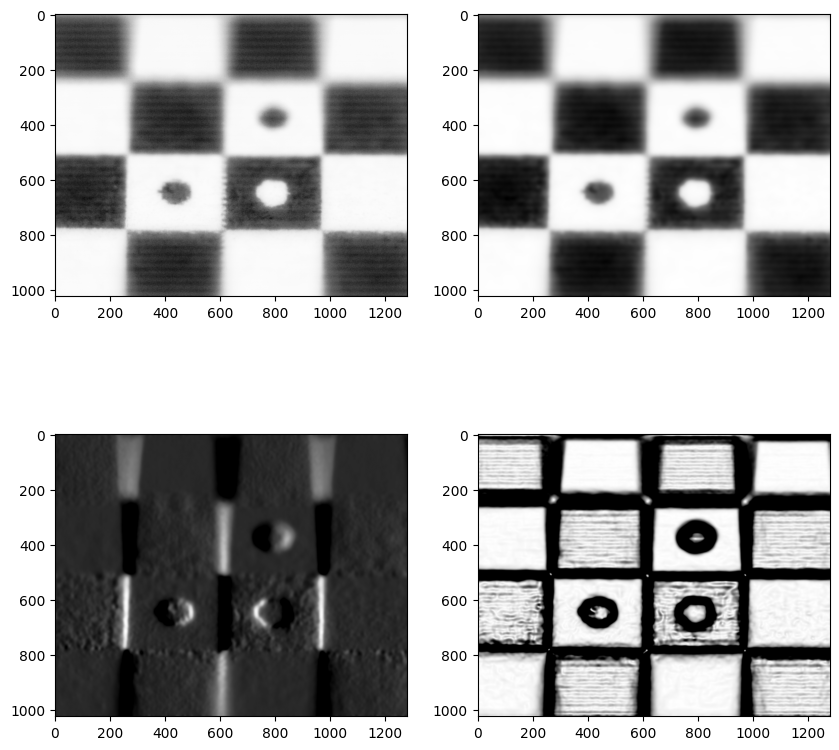

In [36]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(im,cmap='Greys')
plt.subplot(2,2,2)
im_blur = gaussian(im,sigma=5)
plt.imshow(im_blur,cmap='Greys')
plt.subplot(2,2,3)
plt.imshow(sobel_v(im_blur)*100,vmax=1,cmap='Greys')
plt.subplot(2,2,4)
plt.imshow(sobel(im_blur)*100,vmax=1,cmap='Greys')

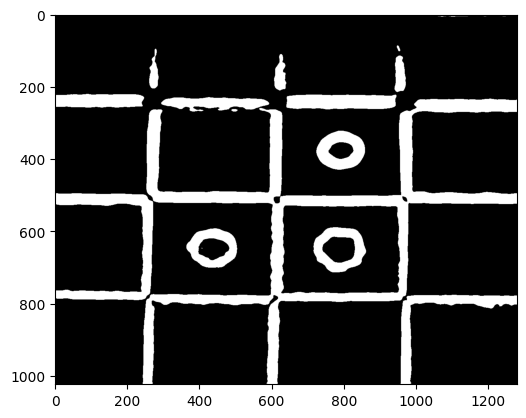

In [37]:
# from skimage.morphology import skeletonize

im_sobel = sobel(im_blur)
# im_sobel = 255 - im_sobel

threshold = im_sobel.max() * BINARY_THRESHOLD


thresholded = im_sobel > threshold

# SOBEL SPACE MAX VALUE DIVIDED BY CONSTANT S.T. EACH IMAGE THRESHOLD DEPENDENT ON CONDITIONS

# thresholded = np.invert(thresholded)
# skeleton = skeletonize(thresholded)
plt.imshow(thresholded,cmap=cm.grey)

# plt.imshow(im_sobel,cmap=cm.grey)

3.08610993385133e-14 504.0
4.776122516674678e-14 780.0
-2.111821590606507 241.99078538152946
950.855158093728 -16.59723852185655
279.8294315653468 9.771859076700272
631.9037433388393 11.02992086836318


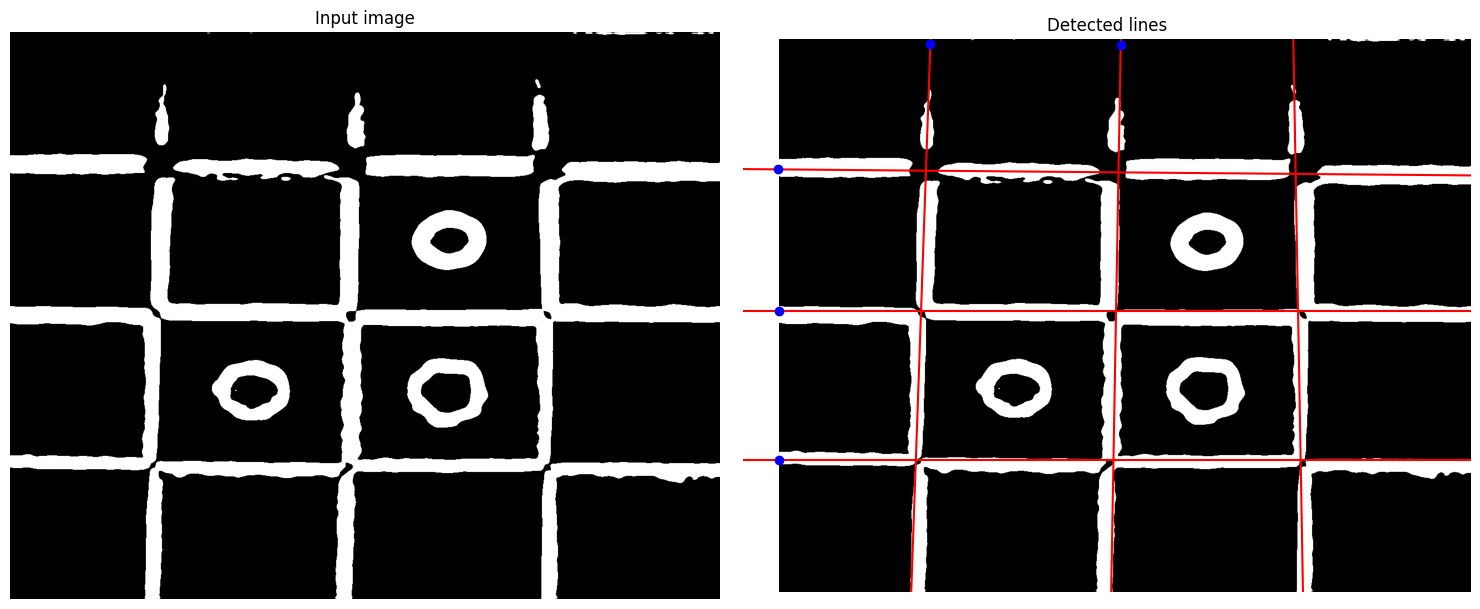

In [38]:
tested_angles = np.linspace(-(np.pi / 2)+(np.pi/2), (np.pi / 2)+(np.pi/2), 360, endpoint=False)

h, theta, d = hough_line(thresholded, theta=tested_angles)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.ravel()
ax[0].imshow(thresholded, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(thresholded, cmap=cm.gray)
ax[1].set_ylim((thresholded.shape[0], 0))
ax[1].set_axis_off()
ax[1].set_title('Detected lines')

line_r0s = []
line_angles = []

for _, angle, dist in zip(*hough_line_peaks(h, theta, d, num_peaks=NUM_LINES, min_distance=100)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    line_r0s.append((x0,y0))
    ax[1].axline((x0, y0), slope=np.tan(angle + np.pi / 2),c='red')
    ax[1].plot(x0,y0,'bo')
    line_angles.append(np.tan(angle + np.pi / 2))
    print(x0,y0)

plt.tight_layout()
plt.show()


In [39]:
def line_intersection(x1, y1, angle1, x2, y2, angle2):
    # Direction vectors
    dx1, dy1 = np.cos(angle1 + np.pi/2), np.sin(angle1 + np.pi/2)
    dx2, dy2 = np.cos(angle2 + np.pi/2), np.sin(angle2 + np.pi/2)
    
    # Check if lines are parallel
    det = dx1 * dy2 - dx2 * dy1
    if abs(det) < 1e-10:
        return None
    
    # Solve for intersection
    # Line 1: (x1, y1) + t1 * (dx1, dy1)
    # Line 2: (x2, y2) + t2 * (dx2, dy2)
    # Set equal and solve for t1
    
    t1 = ((x2 - x1) * dy2 - (y2 - y1) * dx2) / det
    
    x_intersect = x1 + t1 * dx1
    y_intersect = y1 + t1 * dy1
    
    return (x_intersect, y_intersect)

def find_all_intersections(points_angles):
    intersections = []
    n = len(points_angles)
    
    for i in range(n):
        for j in range(i + 1, n):
            x1, y1, angle1 = points_angles[i]
            x2, y2, angle2 = points_angles[j]
            
            intersection = line_intersection(x1, y1, angle1, x2, y2, angle2)
            
            if intersection is not None:
                intersections.append({
                    'point': intersection,
                    'line1_idx': i,
                    'line2_idx': j
                })
    
    return intersections

def hough_intersections(hough_results, image_shape=None, filter_bounds=True):
    _, angles, distances = hough_results
    
    points_angles = []
    for angle, dist in zip(angles, distances):
        # Point on line closest to origin
        x0 = dist * np.cos(angle)
        y0 = dist * np.sin(angle)
        points_angles.append((x0, y0, angle))
    
    intersections = find_all_intersections(points_angles)
    
    if filter_bounds and image_shape is not None:
        height, width = image_shape
        margin = 10  # Allow small margin outside image
        filtered = []
        for inter in intersections:
            x, y = inter['point']
            if -margin <= x <= width + margin and -margin <= y <= height + margin:
                filtered.append(inter)
        intersections = filtered
    
    return intersections

Found 9 intersections
439 648
787 649
791 377


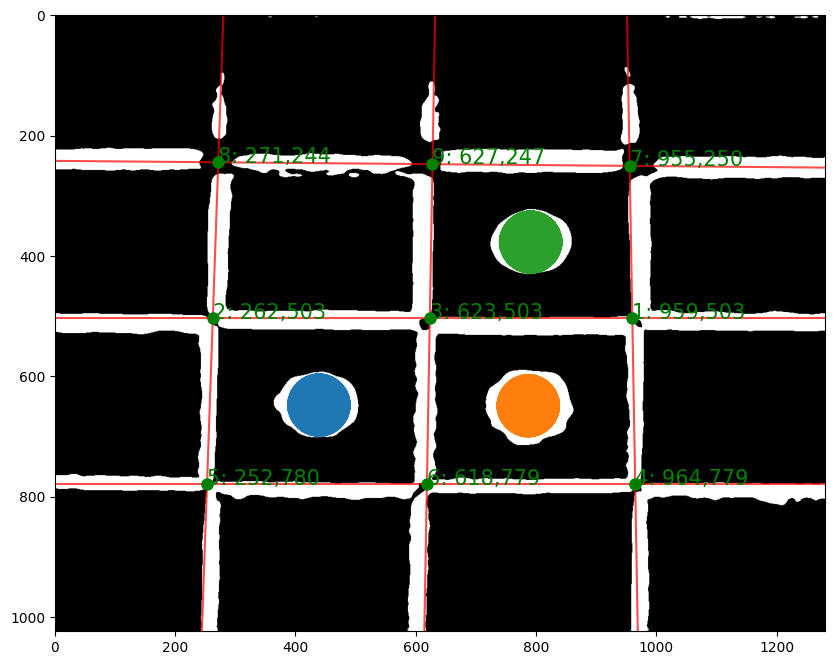

In [46]:
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter
shape = thresholded.shape
rad_min = int(min(shape) / (4*(min(GRID_DIMENSIONS) + 3)))
rad_max = int(max(shape) / (4*(max(GRID_DIMENSIONS) + 1)))

hough_radii = np.arange(rad_min, rad_max, 10)
hough_res = hough_circle(thresholded, hough_radii)

accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=3, min_xdistance = 100, min_ydistance = 100)

peaks = hough_line_peaks(h, theta, d, num_peaks=NUM_LINES, min_distance=100)
intersections = hough_intersections(peaks, thresholded.shape)
print(f"Found {len(intersections)} intersections")
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(thresholded, cmap='gray')

for _, angle, dist in zip(*peaks):
    x0, y0 = dist * np.array([np.cos(angle), np.sin(angle)])
    ax.axline((x0, y0), slope=np.tan(angle + np.pi/2), color='red', alpha=0.7)

k = 0

for inter in intersections:
    x, y = inter['point']
    k = k+1
    ax.plot(x, y, 'go', markersize=8)
    ax.text(x,y,str(k) + ': ' + str(int(x)) +','+ str(int(y)),c = 'g',fontsize = 15)

for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius, shape=thresholded.shape)
    ax.plot(circx, circy)

    print(center_x,center_y)


ax.set_xlim(0, thresholded.shape[1])
ax.set_ylim(thresholded.shape[0], 0)
plt.show()



In [47]:
points = np.array

for inter in intersections:
    x,y = inter['point']
    print(x,y)

959.9422166935777 503.9999999999999
262.5706045798292 503.99999999999994
623.298918599928 503.99999999999994
964.7598146137658 779.9999999999999
252.93247220010684 780.0
618.48132067974 779.9999999999999
955.5147022157868 250.347865447712
271.63674338364126 244.37975291596973
627.776356818787 247.48773623747027


In [162]:
oy_left, ox_left = 621, 520
oy_right, ox_right = 613, 514

pixel_density_left = 1.5/184 # mm/px
pixel_density_right = 4.6/705

L = 2.3 # mm

# Y,X

grid_locations_left = np.array([[-2,-1],[-1,-1],[0,-1],[1,-1],[2,-1], 
                          [-2,1],[-1,1],[0,1],[1,1],[2,1]])
grid_locations_right = np.array([[-1,-1],[0,-1],[1,-1],[-1,1],[0,1],[1,1]])

grid_locations_left = grid_locations_left * L
grid_locations_right = grid_locations_right * L

pixel_positions_left = [
    [56.09376258814864, 740.0],
    [335.13626211239887, 740.0],
    [617.1792186207808, 739.9999999999999],
    [889.0501874133441, 739.9999999999999],
    [1161.533202203056, 739.9999999999999],

    [63.29467288357632, 327.4601254684074],
    [342.37968488178825, 325.0245874663167],
    [624.4656109875077, 322.5628608835583],
    [881.7246072869334, 320.3177956348699],
    [1146.7967962164291, 318.00454568707517]]

pixel_positions_right = [
    [252.93247220010684, 780.0],
    [618.48132067974, 779.9999999999999],
    [964.7598146137658, 779.9999999999999],

    [271.63674338364126, 244.37975291596973],
    [627.776356818787, 247.48773623747027],
    [955.5147022157868, 250.347865447712]]

cam_coords = lambda px_pos, o1, o2, mm_per_px:[
    (px_pos[0] - o1) * mm_per_px,
    -1 * (px_pos[1] - o2) * mm_per_px
    ]

apply = lambda target_list, function, arguments: \
    [function(*((element,) + arguments)) for element in target_list] # function arguments must have format (thing to apply, arguments)

# camera_positions_left = [[(position[0] - oy_left) * pixel_density_left,
#                         -1*(position[1]-ox_left)*pixel_density_left]
#                         for position in pixel_positions_left]
# camera_positions_right = [[(position[0] - oy_right)*pixel_density_right, 
#                         -1*(position[1]-ox_right)*pixel_density_right]
#                         for position in pixel_positions_right]


# camera_positions_left = [cam_coords(px_pos,oy_left,ox_left, pixel_density_left) for px_pos in pixel_positions_left]
# camera_positions_right = [cam_coords(px_pos,oy_right,ox_right, pixel_density_right) for px_pos in pixel_positions_right]


left_parameters = (oy_left, ox_left, pixel_density_left)
right_parameters = (oy_right, ox_right, pixel_density_right)

camera_positions_left = apply(pixel_positions_left, cam_coords, left_parameters)
camera_positions_right = apply(pixel_positions_right, cam_coords, right_parameters)



In [163]:
camera_positions_left

[[-4.605213891944441, -1.7934782608695652],
 [-2.3304109066924004, -1.7934782608695652],
 [-0.0311476742871128, -1.7934782608695643],
 [2.1851917452174794, -1.7934782608695643],
 [4.406520670133608, -1.7934782608695643],
 [-4.546510818883888, 1.5696185423771136],
 [-2.2713612645506394, 1.5894734717419834],
 [0.02825226348511725, 1.609541894970992],
 [2.125472342013044, 1.62784405732443],
 [4.286386925677411, 1.6467020732031916]]

In [164]:
# ASSUMING THE ROTATION OF THE IMAGE IS ZERO, AND THERE IS NO FISHEYE DISTORTION

#  = lambda grid_loc, cam_loc: (cam_loc[1]/abs(cam_loc[1]))*(((grid_loc[0] ** 2) + (grid_loc[1]**2) - (cam_loc[0]**2) - (cam_loc[1]**2)))


# BETTER
phi_approx = lambda grid_loc, cam_loc: np.arcsin(abs(cam_loc[1])/(((grid_loc[0] ** 2) + (grid_loc[1]**2) - (cam_loc[0]**2)))**(1/2))
# SIMPLIFIED
# phi_approx = lambda grid_loc, cam_loc: np.arcsin(cam_loc[1]/grid_loc[1])

phis_left = [phi_approx(grid_locations_left[i], camera_positions_left[i]) for i in range(len(grid_locations_left))]
phis_right = [phi_approx(grid_locations_right[i], camera_positions_right[i]) for i in range(len(grid_locations_right))]

In [165]:
# FIX FIX FIX

phis_left, phis_right

([0.90001263653227,
  0.9114020856435225,
  0.8944176393056001,
  0.8396127157711284,
  0.7427270745197162,
  0.71143085125436,
  0.7514233310955417,
  0.7751925514461315,
  0.7223336453978648,
  0.6180161325827385],
 [0.8812534113747921,
  0.8551985250880129,
  0.8526580438155943,
  0.8362745139431652,
  0.8582938530647838,
  0.8152518179216888])

In [166]:
phi_left_approx = sum(phis_left) / len(phis_left)
phi_right_approx = sum(phis_right) / len(phis_right)

In [167]:
print(f'Left Camera Angle (approximate): {phi_left_approx} radians')
print(f'Right Camera Angle (approximate): {phi_right_approx} radians')

Left Camera Angle (approximate): 0.7866568663548874 radians
Right Camera Angle (approximate): 0.8498216942013395 radians


In [168]:
# GETTING HEIGHTS

px_coords_left = [672,568]
px_coords_right = [536,320]

print(cam_coords(px_coords_left, oy_left, ox_left, pixel_density_left),
      cam_coords(px_coords_right, oy_right, ox_right, pixel_density_right))

[0.4157608695652174, -0.3913043478260869] [-0.5024113475177304, 1.2658156028368792]


In [170]:
# [X,Y,Z]

world_coords = lambda pos_cam_left, pos_cam_right, phi_left, phi_right:[
    ((pos_cam_left[1]/math.sin(phi_left)) - (pos_cam_right[1]/math.cos(phi_right)*math.tan(phi_left)))/(1+(math.tan(phi_right)/math.tan(phi_left))),
    ((-1*pos_cam_left[0]) + pos_cam_right[0]) / 2,
    (pos_cam_right[1]/math.cos(phi_right)) + (pos_cam_left[1] *math.tan(phi_right)/math.tan(phi_left)) / (1+(math.tan(phi_right)/math.tan(phi_left)))
]

In [171]:
world_coords(cam_coords(px_coords_left, oy_left, ox_left, pixel_density_left),
             cam_coords(px_coords_right, oy_right, ox_right, pixel_density_right),
             phi_left_approx,
             phi_right_approx
            )

[-1.1592580353385882, -0.4590861085414739, 1.70953324501575]